# Connection to google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# Installations and data downloads

In [2]:
! mkdir -p ~/.kaggle;
! cp kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c uw-madison-gi-tract-image-segmentation

 99% 2.28G/2.30G [01:25<00:00, 22.0MB/s]
100% 2.30G/2.30G [01:25<00:00, 28.9MB/s]


In [4]:
!unzip /content/uw-madison-gi-tract-image-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/case77/case77_day20/scans/slice_0121_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0122_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0123_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0124_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0125_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0126_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0127_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0128_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0129_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0130_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0131_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0132_266_266_1.50_

# Imports

## connect different python file to the notebook

In [2]:
import sys 
parentDir = F"/content/gdrive/MyDrive/old_version"
sys.path.append(parentDir)

In [3]:
from generator_func import *
from Scores import *
from Evaluation_func import *

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import os
import cv2
import tensorflow as tf
from keras.layers import Input, Conv2D
from keras.models import Model
from tqdm import tqdm


Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## Upload the segemention file

In [5]:
masks = pd.read_csv('train.csv')

In [6]:
masks.id = masks.id.astype(str)
masks[['case_num','day_num','slice','scan_num']] = masks['id'].str.split('_',n=3, expand=True)
masks.drop(['slice'], axis = 1, inplace = True) 

### dropna

In [7]:
masks_without_na = masks.dropna()

## Upload the paths of the images

In [8]:
filelist = []
PATH = '/content/train/'

for root, dirs, files in os.walk(PATH):
	for file in files:
        #append the file name to the list
		filelist.append(os.path.join(root,file))
df_path = pd.DataFrame(sorted(filelist),columns=['path'])
df_path.head()

,path
0,/content/train/case101/case101_day20/scans/sli...
1,/content/train/case101/case101_day20/scans/sli...
2,/content/train/case101/case101_day20/scans/sli...
3,/content/train/case101/case101_day20/scans/sli...
4,/content/train/case101/case101_day20/scans/sli...


In [9]:
print("No. of images = ", len(filelist))

No. of images =  38496


#### Split the path to id and the shape of the image

In [10]:
df_ezer = df_path.path.str.split('/', expand=True)
df_ezer.sample(1)

,0,1,2,3,4,5,6
27964,,content,train,case49,case49_day15,scans,slice_0061_360_310_1.50_1.50.png


In [11]:
df_ezer2 = df_ezer.loc[:,6].str.split('_', expand=True)
df_ezer2.sample(1)

,0,1,2,3,4,5
2122,slice,0107,360,310,1.50,1.50.png


In [12]:
df_path.path = df_path.path.astype(str)
df_path['image_shape'] = list(zip(df_ezer2.loc[:,2],df_ezer2.loc[:,3]))

In [13]:
df_path['id'] = df_ezer.loc[:,4]+"_"+df_ezer2.loc[:,0]+"_"+df_ezer2.loc[:,1]

In [14]:
df_path.sample(1)

,path,image_shape,id
31735,/content/train/case67/case67_day12/scans/slice...,"(266, 266)",case67_day12_slice_0088


In [15]:
#  Table with the path of the image and the corresponding segmentation mask in RLE-format.
masks_paths = pd.merge(masks, df_path)
masks_paths.sample(1)

,id,class,segmentation,case_num,day_num,scan_num,path,image_shape
39626,case49_day15_slice_0137,stomach,NaN,case49,day15,0137,/content/train/case49/case49_day15/scans/slice...,"(360, 310)"


## Create functions go over the images

In [16]:
image_gen = generator_images(masks_paths)

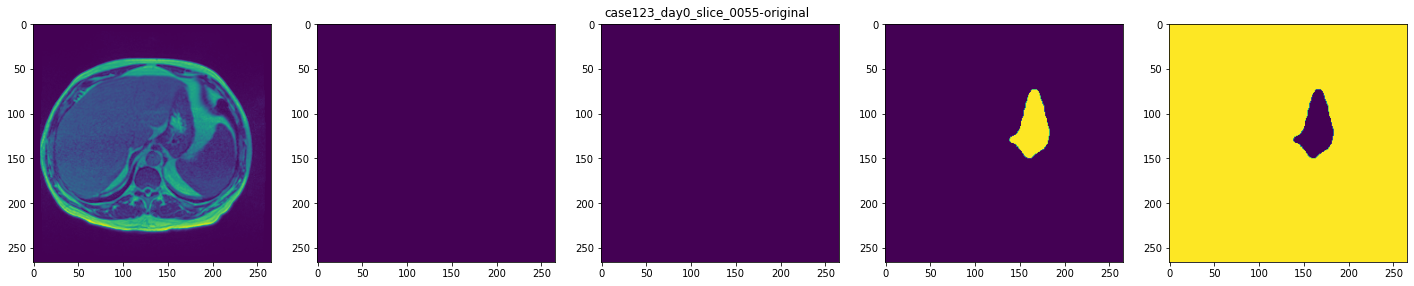

In [17]:
img, img_seg, id_img = next(image_gen)
plot_image_mask(img[:,:,0], img_seg, id_img)

# Split the data

In [18]:
train_ratio = 0.8
validation_ratio = 0.1 #from the test set
test_ratio = 0.1

In [19]:
# masks_without_na=masks

## Split by day

In [20]:
masks_without_na.day_num = masks_without_na.day_num.astype(str)
masks_without_na.day_num = masks_without_na.day_num.apply(lambda word: (''.join(filter(lambda i: i.isdigit(), word)))).astype(int)
masks_without_na.day_num.head()


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


194    20
197    20
200    20
203    20
206    20
Name: day_num, dtype: int64

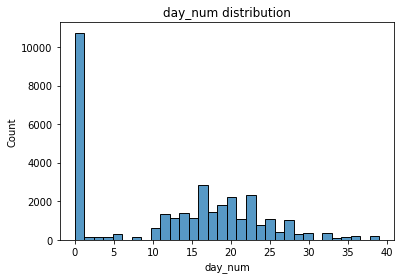

In [21]:
sns.histplot(masks_without_na['day_num'])
plt.title('day_num distribution')
plt.xlabel('day_num');

### Split to train and test set

In [22]:
day_num_count = masks_without_na.groupby('day_num').count().id/masks_without_na.shape[0]

In [23]:
import itertools
import operator
lis=list(itertools.accumulate(day_num_count, add))

In [24]:
ind = [index for index,value in enumerate(lis) if value > train_ratio][0]
ind

20

In [25]:
ind_day = masks_without_na.groupby('day_num').count().index[ind]
ind_day

22

In [26]:
features = masks_without_na.drop(columns='segmentation')
target = masks_without_na['segmentation']

In [27]:
x_train=features[features.day_num < ind_day]
y_train=target[features.day_num < ind_day]
x_val_test=features[features.day_num >= ind_day]
y_val_test=target[features.day_num >= ind_day]

In [28]:
print(f"Percentage of data used for training:{x_train.shape[0]/features.shape[0]}")
print(f"Percentage of data used for testing:{x_val_test.shape[0]/features.shape[0]}")

Percentage of data used for training:0.7848907498599357
Percentage of data used for testing:0.2151092501400643


### Split train set to val and test set

In [29]:
day_num_count = x_val_test.groupby('day_num').count().id/x_val_test.shape[0]
lis=list(itertools.accumulate(day_num_count, add))
ind = [index for index,value in enumerate(lis) if value > 0.5][0]
ind_day = x_val_test.groupby('day_num').count().index[ind]

In [30]:
x_test=x_val_test[x_val_test.day_num < ind_day]
y_test=y_val_test[x_val_test.day_num < ind_day]
x_val=x_val_test[x_val_test.day_num >= ind_day]
y_val=y_val_test[x_val_test.day_num >= ind_day]

In [31]:
print(f"Percentage of data used for validation:{x_val.shape[0]/features.shape[0]}")
print(f"Percentage of data used for testing:{x_test.shape[0]/features.shape[0]}")

Percentage of data used for validation:0.12417067201368207
Percentage of data used for testing:0.09093857812638222


In [32]:
assert set(x_train['day_num']) & set(x_val['day_num']) == set()
assert set(x_val['day_num']) & set(x_test['day_num']) == set()

In [33]:
x_train.reset_index(drop=True, inplace=True)

## Split by case

In [34]:
from sklearn.model_selection import GroupShuffleSplit

gs_1 = GroupShuffleSplit(n_splits=1, test_size=1 - train_ratio, random_state=42)
train_ix, val_test_ix = next(gs_1.split(x_train,y_train, groups=x_train['case_num']))
x_train_case=x_train.iloc[train_ix,:]
y_train_case=y_train.iloc[train_ix]
x_val_test_case=x_train.iloc[val_test_ix,:]
y_val_test_case=y_train.iloc[val_test_ix]

gs_2 = GroupShuffleSplit(n_splits=1, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)
val_ix, test_ix = next(gs_2.split(x_val_test_case, y_val_test_case, groups=x_val_test_case['case_num']))
x_val_case=x_val_test_case.iloc[val_ix,:]
y_val_case=y_val_test_case.iloc[val_ix]
x_test_case=x_val_test_case.iloc[test_ix,:]
y_test_case=y_val_test_case.iloc[test_ix]

In [35]:
print(f"Percentage of case_num in training: {x_train_case['case_num'].nunique()/x_train['case_num'].nunique()}")
print(f"Percentage of case_num in validation: {x_val_case['case_num'].nunique()/x_train['case_num'].nunique()}")
print(f"Percentage of case_num in testing: {x_test_case['case_num'].nunique()/x_train['case_num'].nunique()}")

Percentage of case_num in training: 0.8
Percentage of case_num in validation: 0.09411764705882353
Percentage of case_num in testing: 0.10588235294117647


In [36]:
assert set(x_train_case['case_num']) & set(x_val_case['case_num']) == set()
assert set(x_val_case['case_num']) & set(x_test_case['case_num']) == set()

In [37]:
print(f"Percentage of data used for training:{x_train_case.shape[0]/x_train.shape[0]}")
print(f"Percentage of data used for testing:{x_test_case.shape[0]/x_train.shape[0]}")
print(f"Percentage of data used for validation:{x_val_case.shape[0]/x_train.shape[0]}")

Percentage of data used for training:0.8030655947103463
Percentage of data used for testing:0.08486738297392742
Percentage of data used for validation:0.1120670223157262


In [38]:
print(f"case_num in training: {x_train_case['case_num'].nunique()}")
print(f"case_num in validation: {x_val_case['case_num'].nunique()}")
print(f"case_num in testing: {x_test_case['case_num'].nunique()}")

case_num in training: 68
case_num in validation: 8
case_num in testing: 9


## Combine the splits

In [39]:
x_train = x_train_case

In [40]:
x_val = pd.concat([x_val_case,x_val])


In [41]:
x_test = pd.concat([x_test_case,x_test])

In [42]:
print(f"Percentage of data used for training:{x_train.shape[0]/masks_without_na.shape[0]}")
print(f"Percentage of data used for testing:{x_test.shape[0]/masks_without_na.shape[0]}")
print(f"Percentage of data used for validation:{x_val.shape[0]/masks_without_na.shape[0]}")

Percentage of data used for training:0.630318756818919
Percentage of data used for testing:0.15755020198743844
Percentage of data used for validation:0.21213104119364257


## Train/valid/test dataframes to create generators

In [43]:
train_img_paths = masks_paths[masks_paths['id'].isin(x_train.id)]
len(train_img_paths)/3

10356.0

In [44]:
val_img_paths = masks_paths[masks_paths['id'].isin(x_val.id)]
len(val_img_paths)/3

3586.0

In [45]:
test_img_paths = masks_paths[masks_paths['id'].isin(x_test.id)]
len(test_img_paths)/3

2648.0

In [46]:
images_per_classes = train_img_paths.dropna().groupby(by = 'id').agg(number_of_classes = ('class', 'count')).value_counts().sort_index()
images_per_classes

number_of_classes
1                    1435
2                    6822
3                    2099
dtype: int64

# model

In [52]:
!pip3 install tensorflow==2.2
!pip3 install keras==2.3.1
!pip3 install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 516.2 MB 4.4 kB/s 
     |████████████████████████████████| 3.0 MB 46.3 MB/s 
     |████████████████████████████████| 2.9 MB 58.0 MB/s 
     |████████████████████████████████| 454 kB 61.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 377 kB 35.2 MB/s 
     |████████████████████████████████| 50 kB 795 kB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import segmentation_models as sm
import keras
import tensorflow as tf
import keras.backend as K
keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


In [48]:
# Set hyperparameters to the model
BATCHSIZE = 32
BACKBONE = 'resnet34'
IMG_DIM = (256, 256)
ENCODER_WEIGHTS = 'imagenet'
NUM_CLASSES = 4
MODEL_NAME = 'classifier_cvresize_iouth.ckpt'
PATH = parentDir+"/"+MODEL_NAME
LR = 0.0001 
EPOCHS = 5
INTERPOLATION=cv2.INTER_NEAREST

In [49]:
# Create the train and validation generators
traingen = generator_batch_images(IMG_DIM, train_img_paths, batchsize=BATCHSIZE, interpolation=INTERPOLATION)
valgen = generator_batch_images(IMG_DIM, val_img_paths, batchsize=BATCHSIZE, interpolation=INTERPOLATION)
# check that the creation work
img, img_seg = next(traingen)
img, img_seg = next(valgen)

In [50]:
def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

# Calculate the steps per epoch
train_steps = calc_steps(len(train_img_paths), BATCHSIZE)
val_steps = calc_steps(len(val_img_paths), BATCHSIZE)

In [51]:
# map N channels data to 3 channels, in our case 1 channel beacuse the image gray scale
N = 1

base_model = sm.Unet(backbone_name = BACKBONE, classes = NUM_CLASSES, encoder_weights = ENCODER_WEIGHTS)
inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) 
out = base_model(l1)

model = Model(inp, out, name=base_model.name)

85524480/85521592 [==============================] - 8s 0us/step


In [52]:
# Define callbacks
callback_save = keras.callbacks.ModelCheckpoint(filepath = PATH, monitor = 'val_loss', save_best_only = True, save_weights_only = True, verbose=1)
callback_early = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
callbacks=[callback_early,callback_save]

# Multi

In [53]:
NUM_EXAMPLES = 5
LOSSES_NAMES = ['focal_weighted_dice_loss_pretrained']#['focal_dice_loss_pretrained'] # 'cce_dice_loss_pretrained',#['bce_jaccard_loss2','cce_jaccard_loss',
EPOCHS=5

In [54]:
weighted_small_dice_loss = sm.losses.DiceLoss(class_weights=np.array([2, 2, 2, 0.5]))
weighted_big_dice_loss = sm.losses.DiceLoss(class_weights=np.array([4, 4, 4, 0.5]))
weighted_huge_dice_loss = sm.losses.DiceLoss(class_weights=np.array([100, 100, 100, 0.5]))
dice_loss =  sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
focal_dice_loss = dice_loss + focal_loss
# weighted_small_focal_dice_loss = weighted_small_dice_loss + focal_loss
# weighted_small_cce_dice_loss = weighted_small_cce_loss + focal_loss
# weighted_big_focal_dice_loss = weighted_small_dice_loss + focal_loss
weighted_huge_focal_dice_loss = weighted_huge_dice_loss + focal_loss
# losses=[sm.losses.bce_jaccard_loss,
# losses=[sm.losses.cce_jaccard_loss,
# losses=[sm.losses.cce_dice_loss]
# losses=[focal_dice_loss]
losses=[weighted_huge_focal_dice_loss]
# weighted_small_cce_dice_loss]

Epoch 1/5
971/971 [==============================] - 919s 946ms/step - loss: -35.2813 - iou_score: 0.6020 - f1-score: 0.6936 - val_loss: 0.7977 - val_iou_score: 0.2418 - val_f1-score: 0.2485

Epoch 00001: val_loss improved from inf to 0.79773, saving model to /content/gdrive/MyDrive/old_version/focal_weighted_dice_loss_pretrained.ckpt
Epoch 2/5
971/971 [==============================] - 893s 919ms/step - loss: -65.3764 - iou_score: 0.8527 - f1-score: 0.9183 - val_loss: -55.4518 - val_iou_score: 0.7322 - val_f1-score: 0.8361

Epoch 00002: val_loss improved from 0.79773 to -55.45181, saving model to /content/gdrive/MyDrive/old_version/focal_weighted_dice_loss_pretrained.ckpt
Epoch 3/5
971/971 [==============================] - 888s 915ms/step - loss: -67.5871 - iou_score: 0.8812 - f1-score: 0.9355 - val_loss: -58.4221 - val_iou_score: 0.7180 - val_f1-score: 0.8255

Epoch 00003: val_loss improved from -55.45181 to -58.42205, saving model to /content/gdrive/MyDrive/old_version/focal_weight

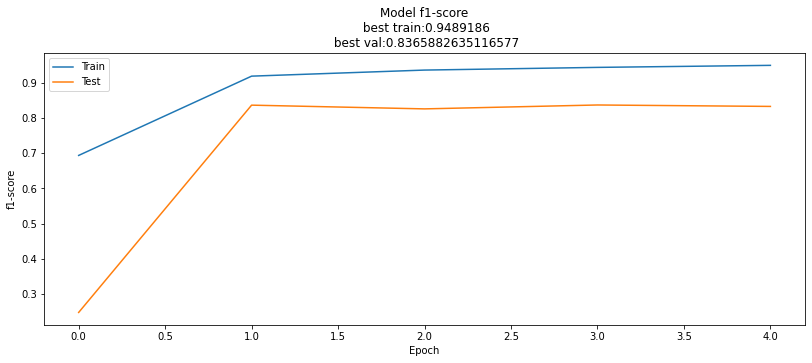

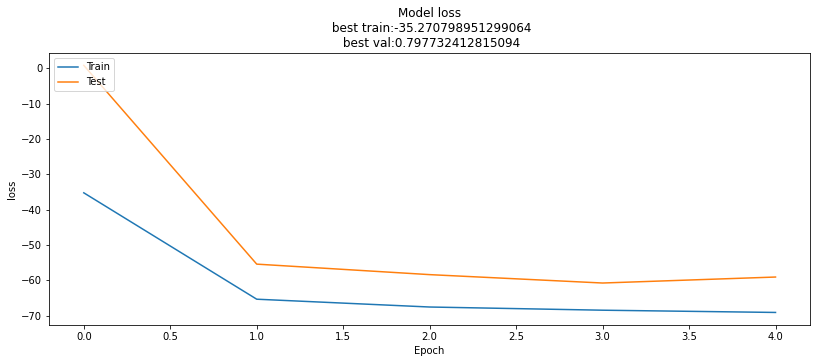

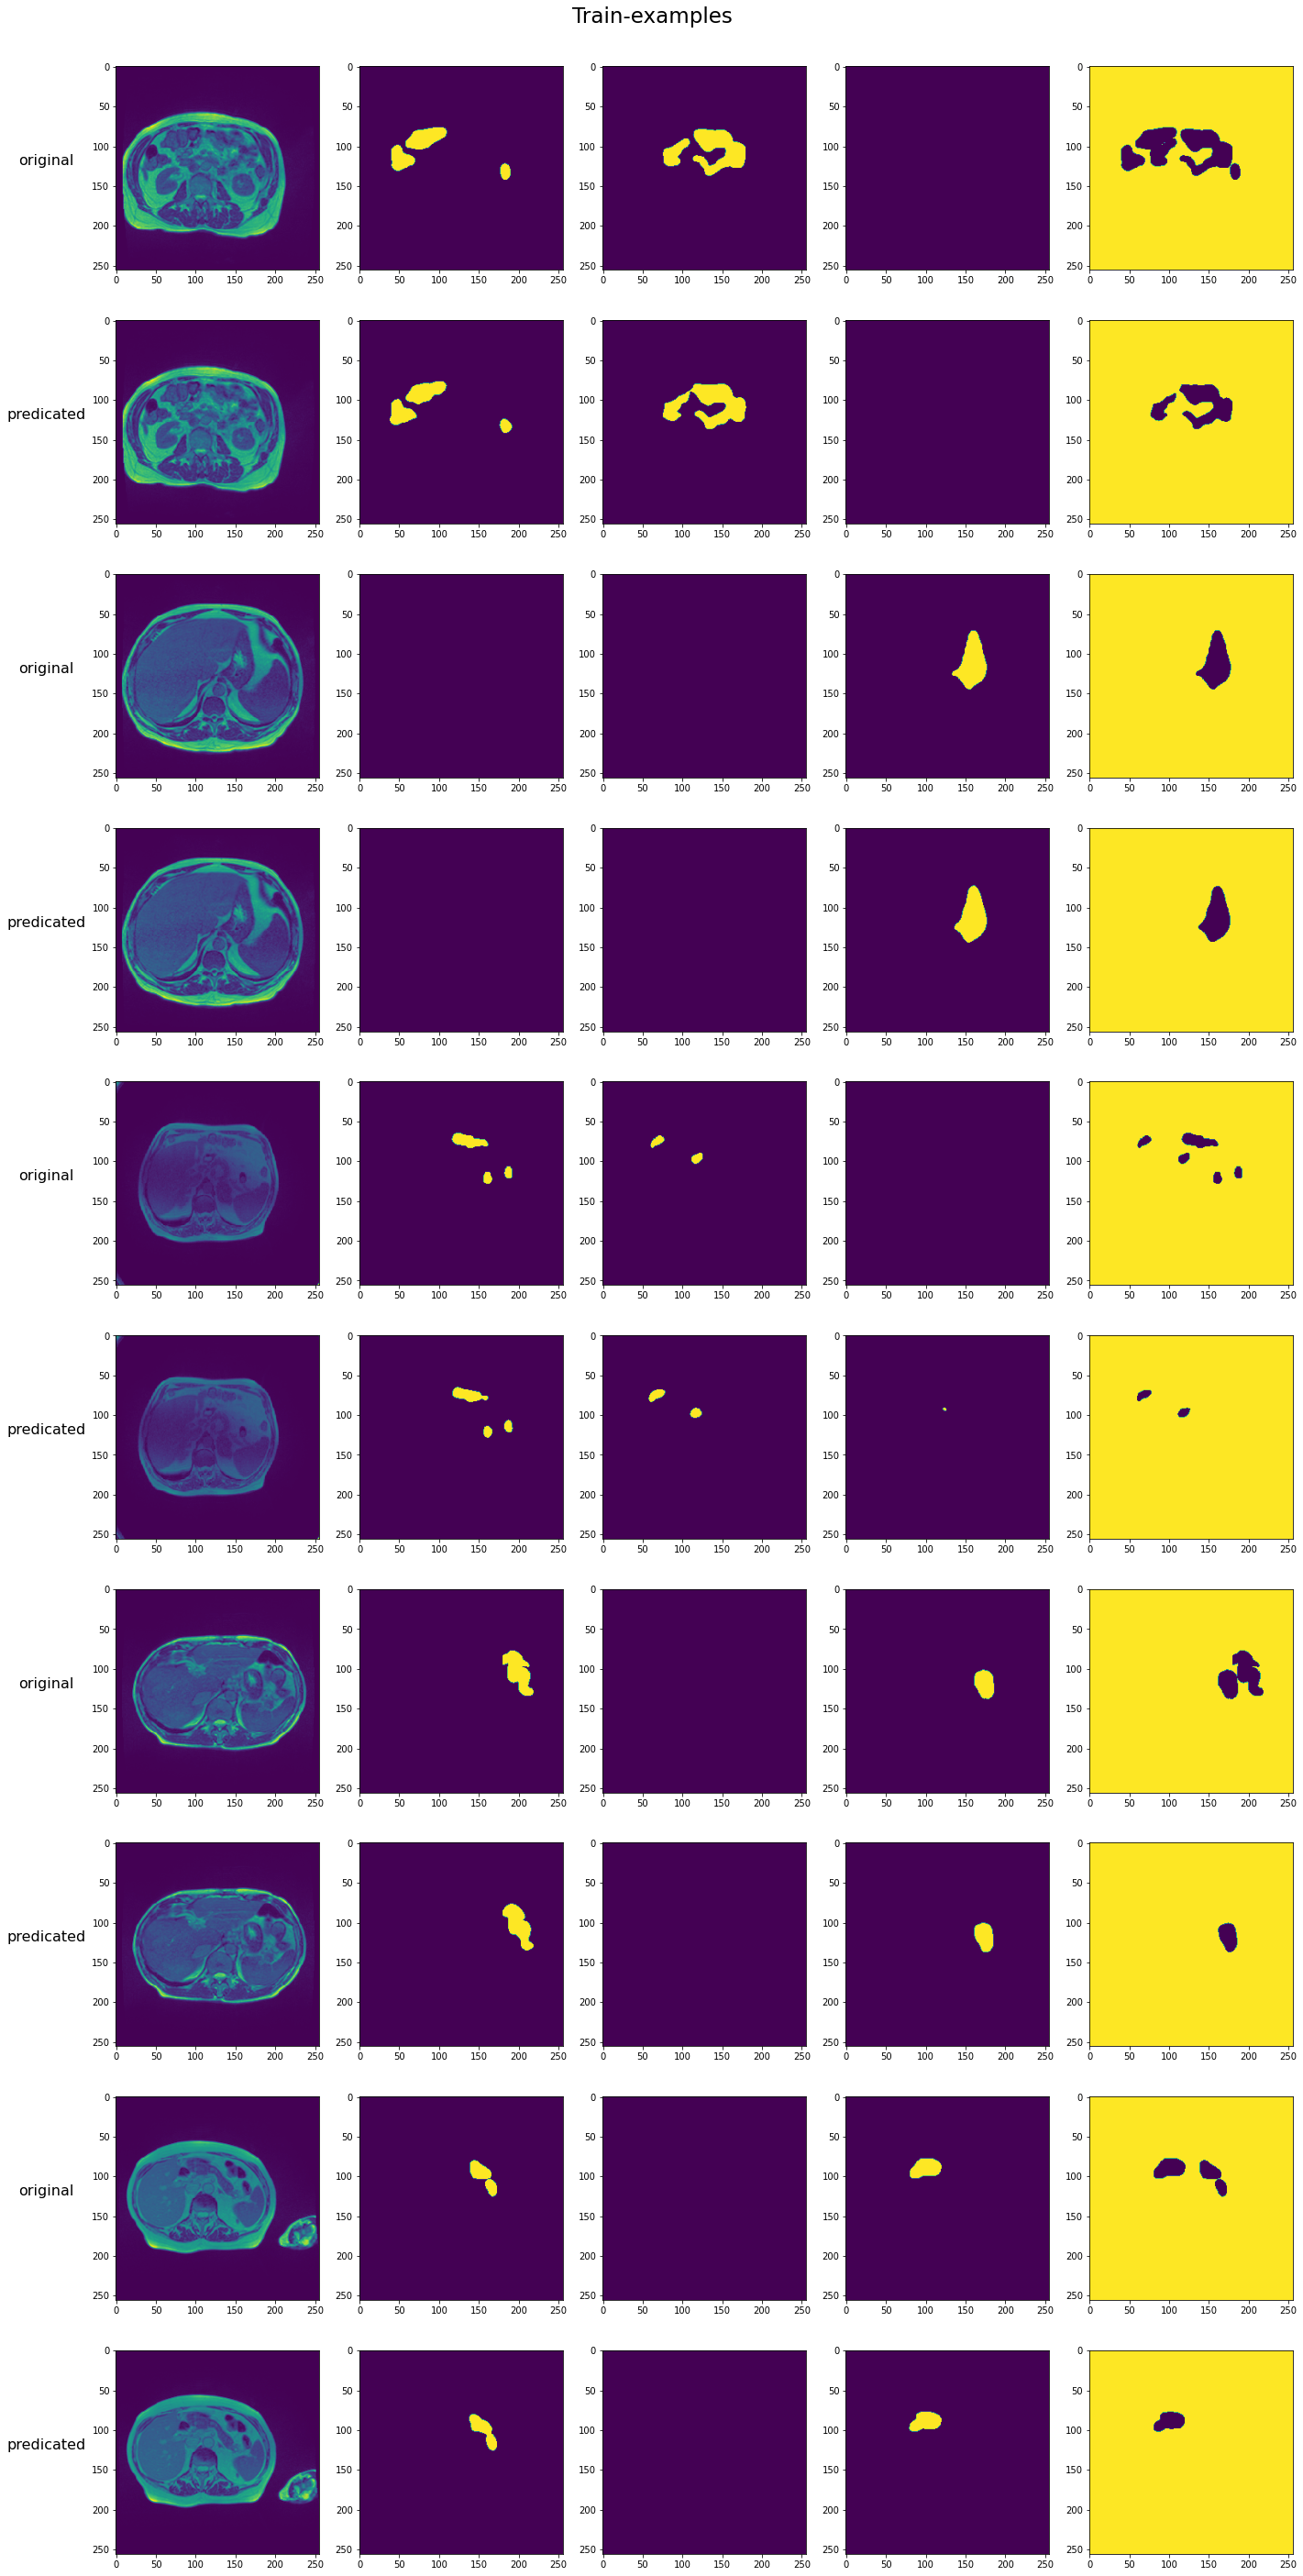

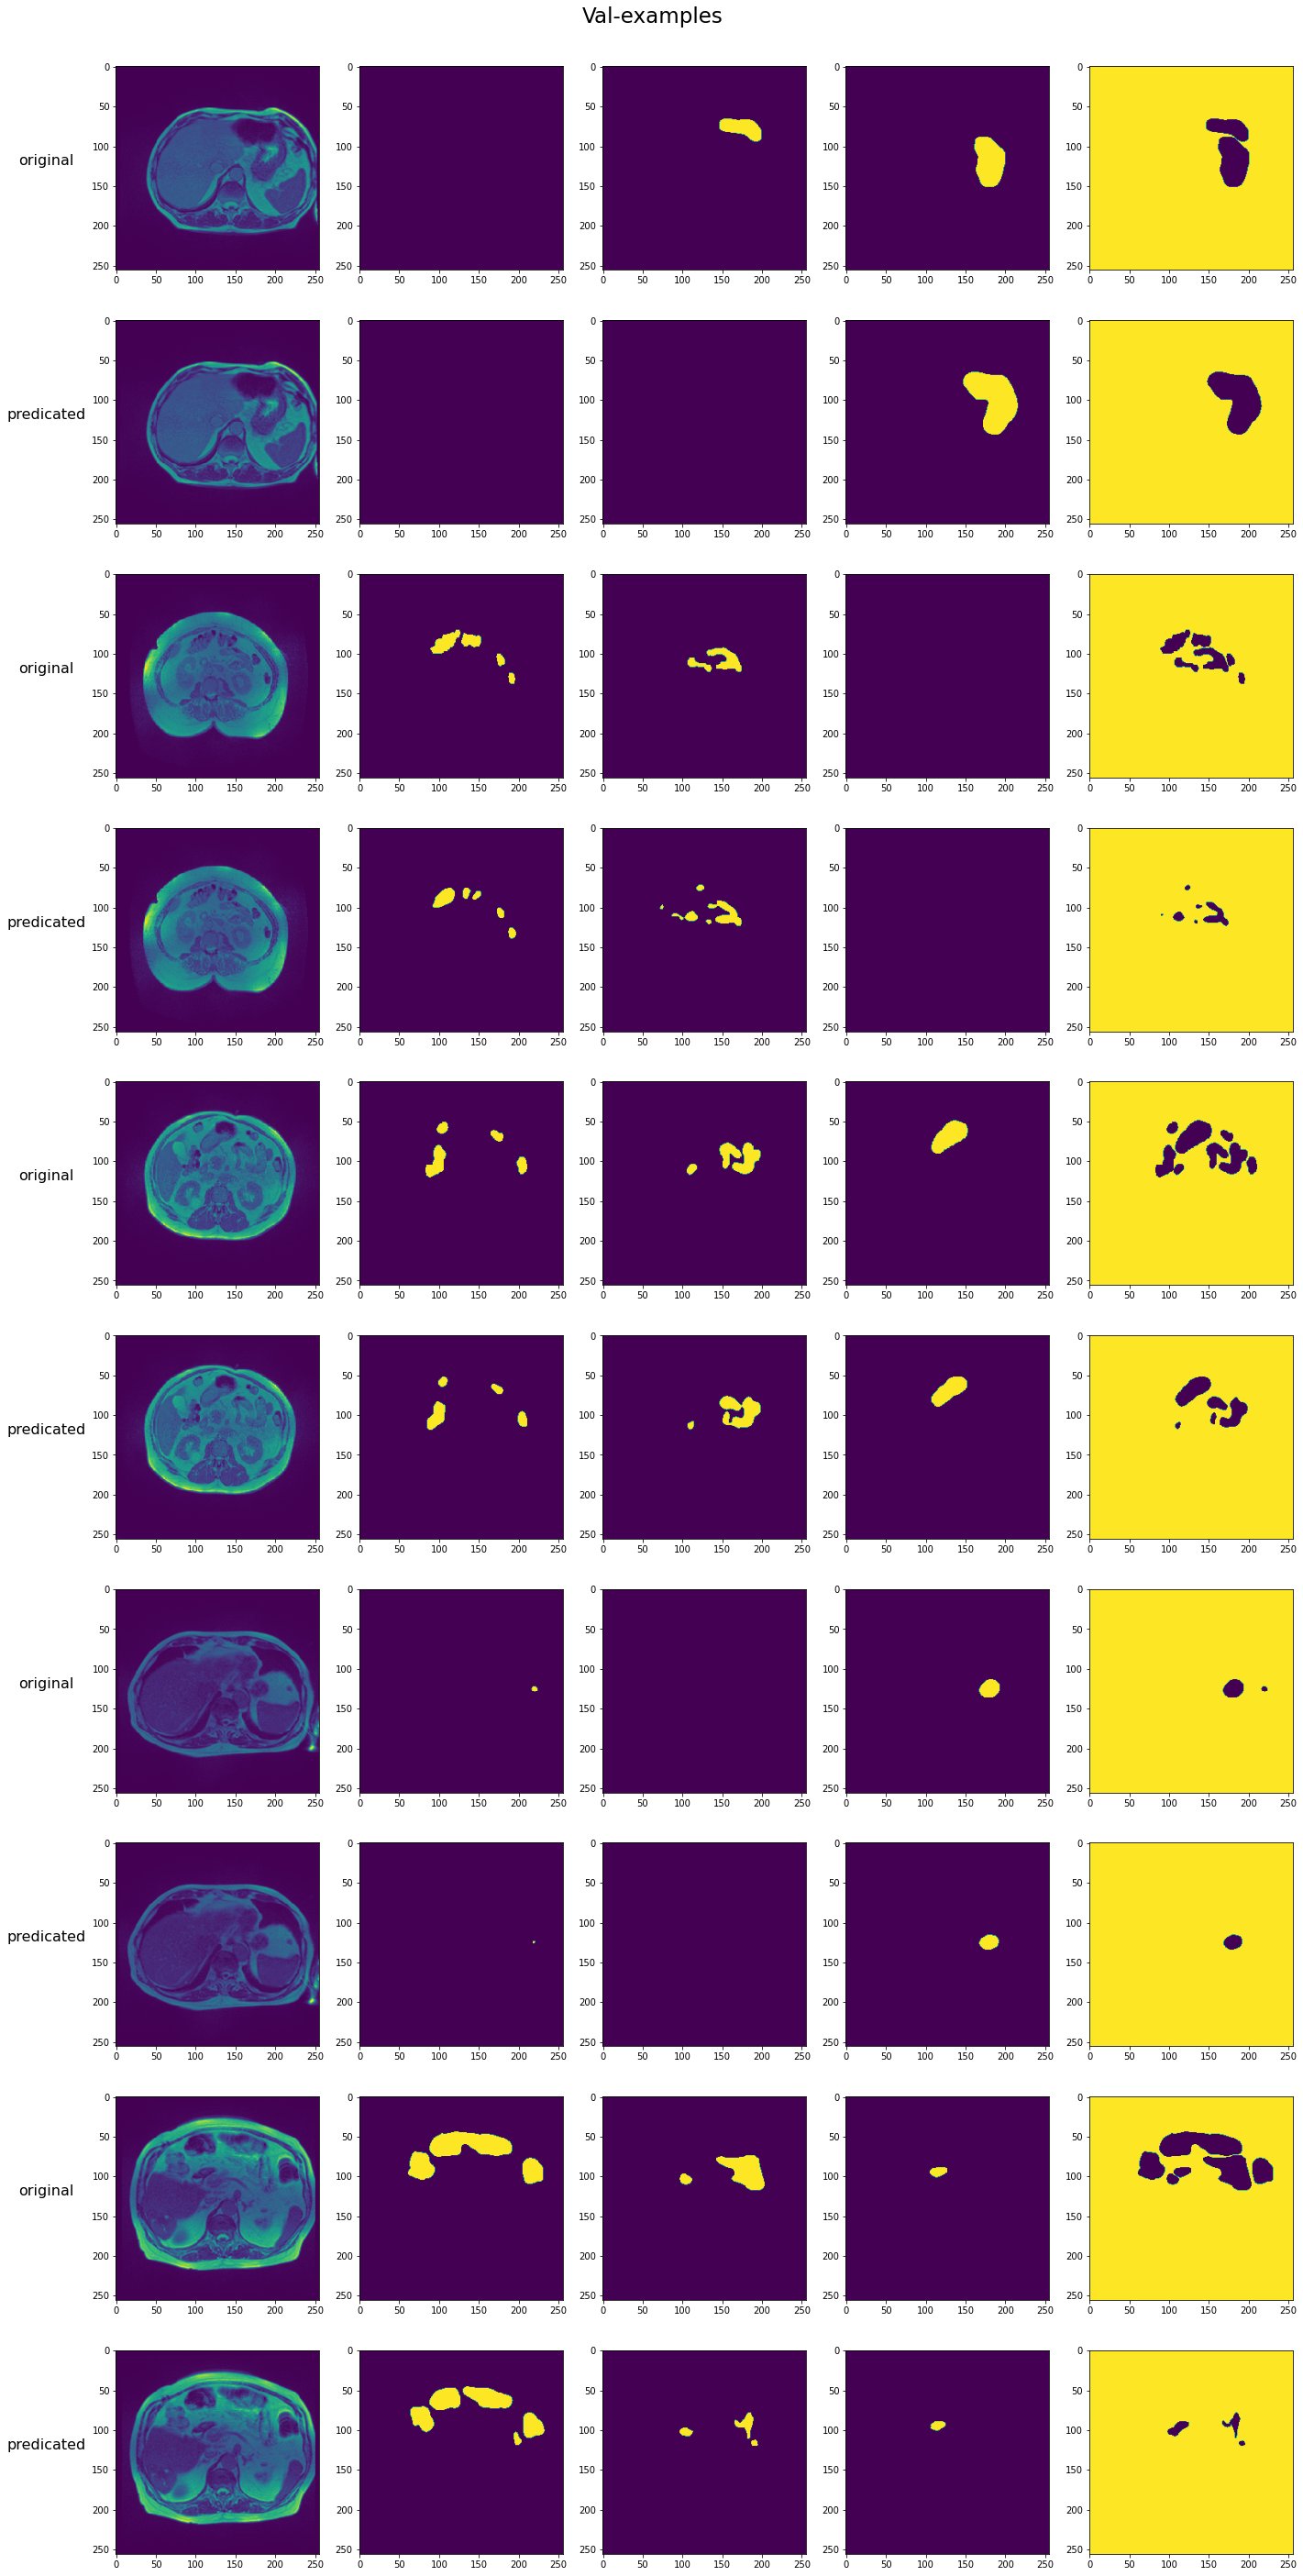

In [55]:
for loss_name_pos, loss in enumerate(losses):
  MODEL_NAME = LOSSES_NAMES[loss_name_pos]+'.ckpt'
  PATH = parentDir+"/"+MODEL_NAME
  callback_save = keras.callbacks.ModelCheckpoint(filepath = PATH, monitor = 'val_loss', save_best_only = True, save_weights_only = True, verbose=1)
  callback_early = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
  callbacks=[callback_early,callback_save]
  model.compile(optimizer=tf.keras.optimizers.Adam(LR),
                loss=loss,
                metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])
  # model.load_weights(PATH)
  history = model.fit_generator(traingen,
                                steps_per_epoch=train_steps,
                                epochs=EPOCHS, # Change this to a larger number to train for longer
                                validation_data=valgen,
                                validation_steps=val_steps, 
                                verbose=1,
                                max_queue_size=5,  # Change this number based on memory restrictions
                                callbacks=callbacks)
  plot_history(history, 'f1-score', PATH)
  plot_history(history, 'loss', PATH)
  plot_examples(train_img_paths,"Train", NUM_EXAMPLES, IMG_DIM, INTERPOLATION, model, PATH)
  plot_examples(val_img_paths,"Val", NUM_EXAMPLES, IMG_DIM, INTERPOLATION, model, PATH)

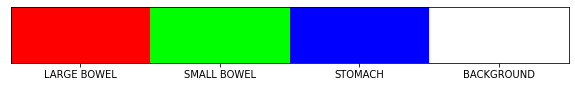

In [57]:
import json

LABEL_CONFIG_FN = 'label_config.json'
with open(LABEL_CONFIG_FN, 'r') as f:
  label_config = json.load(f)

N_LABELS = len(label_config)
LABEL_NAMES = sorted(label_config, key=lambda k: label_config[k]['index'])
LABEL_COLORS = np.array([label_config[n]['color'] for n in LABEL_NAMES])

plt.figure(figsize=(10, 10))
plt.imshow(LABEL_COLORS[None], aspect=0.4)
plt.xticks(range(N_LABELS), LABEL_NAMES)
plt.yticks([])
plt.show() 

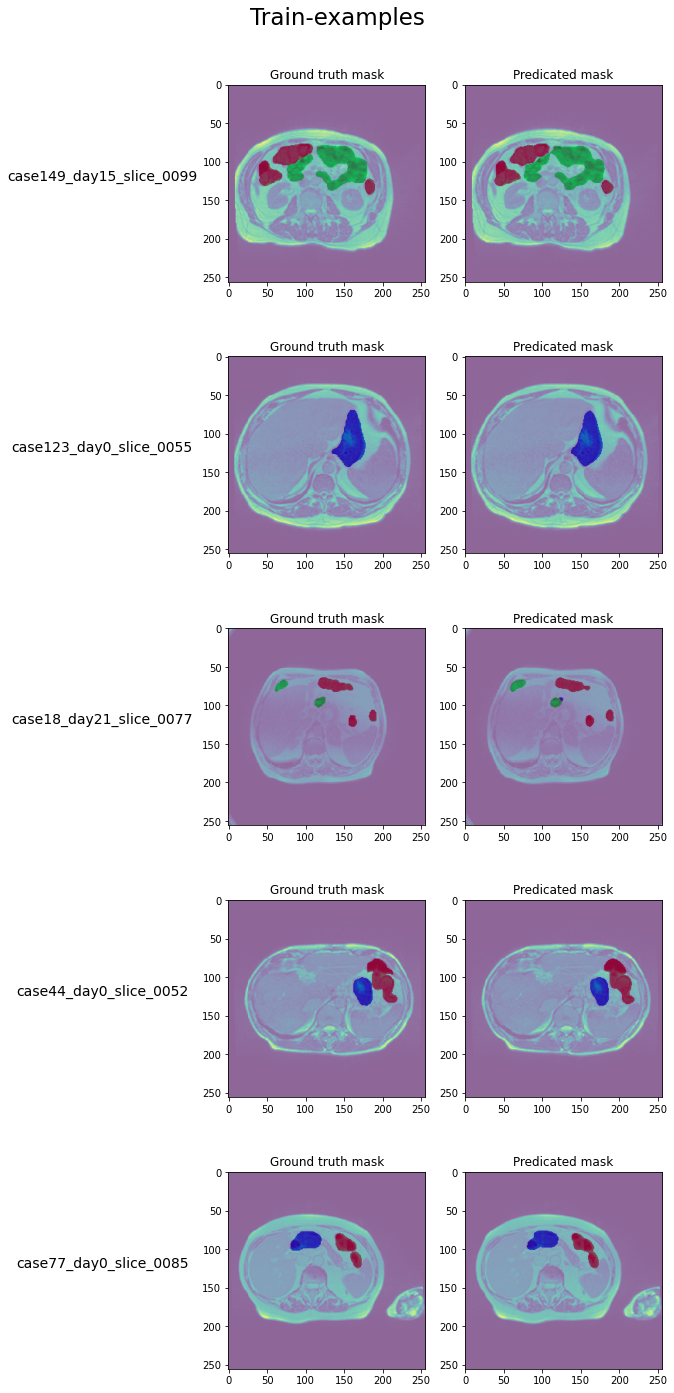

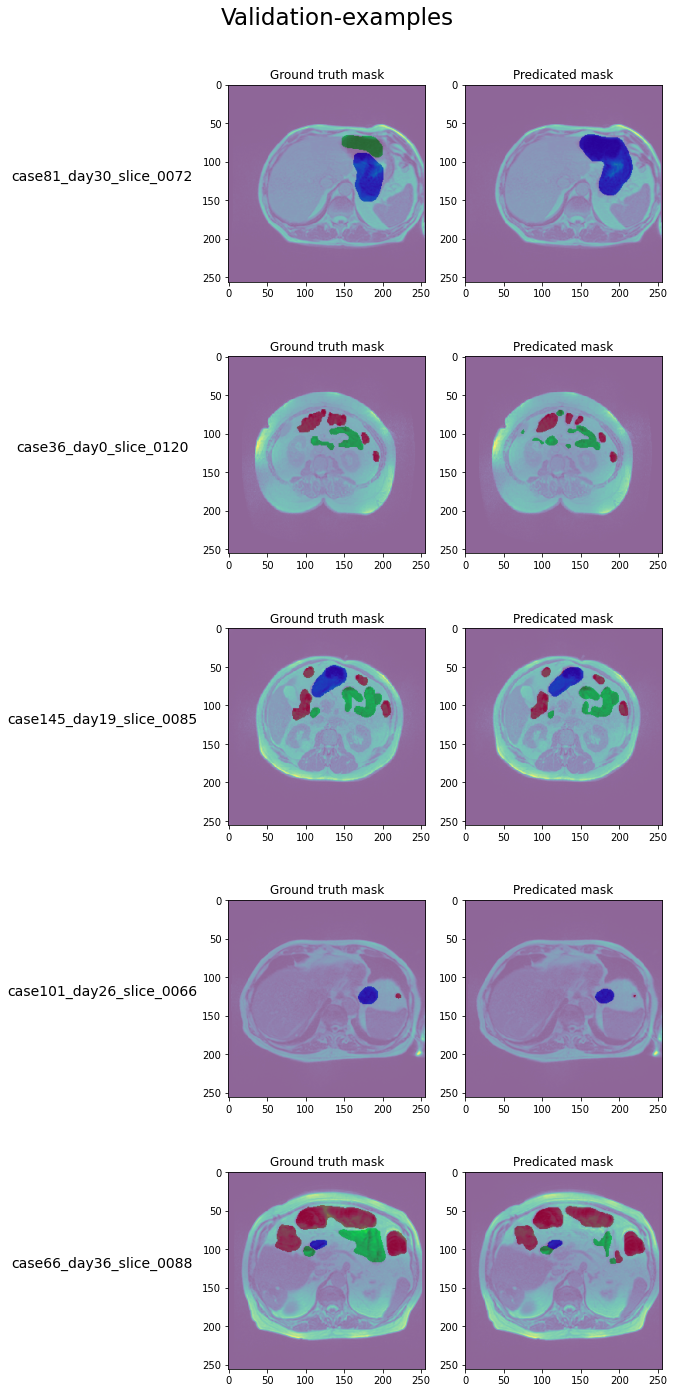

In [58]:
# def plot_row_all_in_one(fig, num_rows, num_cols, number, title, img, img_seg, predict_seg, LABEL_COLORS):
#     """
#     Plot original image and the corresponding mask. The ground truth mask and the predicated mask
#     :param fig: Image that include few rows of examples
#     :param num_rows:
#     :param num_cols:
#     :param number: The position of the current row
#     :param title: To mention original/predicated in the title of the row
#     :param img: image (H,W,1)
#     :param img_seg: Ground truth mask (H,W,4) 3 classes and 1 background
#     :param predict_seg: Predicated mask (H,W,4) 3 classes and 1 background
#     :return:
#     """
#     ax = fig.add_subplot(num_rows, num_cols, number)
#     ax.set_ylabel(title, rotation=0, labelpad=100, fontsize=14)
#     ax.set_title("Ground truth mask")
#     mask_labels = img_seg.argmax(axis=2)
#     mask = LABEL_COLORS[mask_labels]
#     ax.imshow(img)
#     ax.imshow(mask, alpha=0.4)
#     ax = fig.add_subplot(num_rows, num_cols, number + 1)
#     ax.set_title("Predicated mask")
#     mask_labels = predict_seg.argmax(axis=2)
#     mask = LABEL_COLORS[mask_labels]
#     ax.imshow(img)
#     ax.imshow(mask, alpha=0.4)
#     plt.tight_layout(pad=2)
#     fig.subplots_adjust(top=1.5)


# def plot_examples_all_in_one(paths, name_set, num_examples, img_dim, interpolation, model, path, LABEL_COLORS):
#     """
#     Plot examples of the results of the model, the original image and mask and below is the predicated mask.
#     :param paths: The paths of the images
#     :param name_set: Train/ valid/ test set
#     :param num_examples: Number of examples
#     :param img_dim: The new image dimension
#     :param interpolation: the interpolation method for resize
#     :param model:
#     :param path: Directory path to save the example images
#     """
#     fig = plt.figure(figsize=(10, 20))
#     plt.suptitle(name_set + "-examples", fontsize=23)
#     num_rows = num_examples
#     num_cols = 2
#     image_gen = generator_images(paths)

#     for number in range(1, num_cols * num_rows + 1, num_cols):
#         img, img_seg, id_img = next(image_gen)

#         img = cv2.resize(img, img_dim, interpolation=interpolation)
#         img_seg = cv2.resize(img_seg, img_dim, interpolation=interpolation)

#         x = img.reshape(1, 256, 256, 1)

#         y = np.round(model.predict(x))

#         plot_row_all_in_one(fig, num_rows, num_cols, number, id_img, img, img_seg, y[0, :, :, :], LABEL_COLORS)
#     plt.tight_layout(pad=3)
#     fig.subplots_adjust(top=0.95, bottom=0.01, hspace=0.02, wspace=0.2)
#     plt.savefig(path + "_" + name_set + '-examples.png')
plot_examples_all_in_one(train_img_paths,"Train", NUM_EXAMPLES, IMG_DIM, INTERPOLATION, model, PATH, LABEL_COLORS)
plot_examples_all_in_one(val_img_paths,"Validation", NUM_EXAMPLES, IMG_DIM, INTERPOLATION, model, PATH, LABEL_COLORS)